<h1 align=center><font size = 5>Segmenting and Clustering Neighbourhoods in Toronto</font></h1>


## Introduction

As part of this assignment, we explore, segment and cluster the neighborhoods in the city of Toronto. We utilize a Wikipedia page to read in Toronto neighborhood data. We scrape the Wikipedia page to extract data and read it into a pandas dataframe by using pandas.

We convert addresses into their equivalent latitude and longitude values and use the Foursquare API to explore neighborhoods in Toronto. We get the most common venue categories in each neighborhood, and then group the neighborhoods into clusters by using the. *k*-means clustering algorithm. Finally, the Folium library is used to visualize the neighborhoods in Toronto and their emerging clusters.

## **Question 1: Solution steps start here**

#### Let's ensure to install all the dependent components first

In [1]:
%%capture 
# Ignore command line output
!conda install -c anaconda lxml --yes
!conda install -c anaconda html5lib
!conda install -c anaconda BeautifulSoup4 --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

We import all the libraries needed for this program

In [2]:
import numpy as np
import pandas as pd
from lxml import html # For reading html pages
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
from sklearn.cluster import KMeans # import k-means from clustering stage
# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Download and Explore Dataset

Let's download the web page by using the Pandas library. Pandas reads in the wikipedia page as a list. The first element in this list is the dataframe with the actual data that we need.

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
toronto_wiki = pd.read_html(url)
df_t = pd.DataFrame(toronto_wiki[0])
df_t.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


Let's drop cells with no borough i.e. Name of the Borough is 'Not assigned'

In [4]:
df_t = df_t.drop(df_t[df_t['Borough'] == 'Not assigned'].index, axis=0).reset_index(drop = True)
df_t.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


The wikipedia page appears to have been updated to address the following requirement:

_More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table_

Let's verify whether this requirement is met already

In [5]:
if len(df_t['Postal Code'].unique()) != len(df_t['Postal Code']):
    print("Multiple entries for the same postal code")
else:
    print("Only unique entries for all the postal codes")

Only unique entries for all the postal codes


The wikipedia page appears to have been updated to match the following requirement:

_If a cell has a borough but a Not assigned neighbourhood, then the neighbourhood will be the same as the borough_

Let's verify whether this requirement is met already

In [6]:
if len(df_t[df_t['Neighbourhood'] == 'Not assigned']) == 0:
    print("Found no 'Not assigned' neighbourhood for any Boroughs")
else:
    print("Found 'Not assigned' neighbourhoods for Boroughs")

Found no 'Not assigned' neighbourhood for any Boroughs


Check and identify whether a Neighbourhood belongs to more than one Borrough. Not an explicit ask as per the assessment though

In [7]:
if len(df_t['Neighbourhood'].unique()) != len(df_t['Neighbourhood']):
    print("Multiple entries for the same Neighbourhood")
    print()
    print(df_t['Neighbourhood'].value_counts().loc[lambda x: x > 1])
    print()
    print(df_t.groupby('Neighbourhood').filter(lambda x: len(x) > 1))
else:
    print("Only unique entries for all the Neighbourhood")

Multiple entries for the same Neighbourhood

Downsview    4
Don Mills    2
Name: Neighbourhood, dtype: int64

   Postal Code     Borough Neighbourhood
7          M3B  North York     Don Mills
13         M3C  North York     Don Mills
40         M3K  North York     Downsview
46         M3L  North York     Downsview
53         M3M  North York     Downsview
60         M3N  North York     Downsview


In [8]:
df_t.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


## **Answer 1: Here's the output of the .shape method that prints the number of rows of the dataframe**

In [9]:
print("The shape of the dataframe is:", df_t.shape)
print("The number of rows of the dataframe is:", df_t.shape[0])

The shape of the dataframe is: (103, 3)
The number of rows of the dataframe is: 103



---


## **Question 2: Solution steps start here**

Let's first convert the postal code to latitude and longitude as this is a prerequisite to utilize the Foursquare location data

**Geocode API did not work. Hence not purusing the same**

In [10]:
%%capture 
# On execution we ignore the output
# !pip install geocoder

In [11]:
# Commented the following as the Geocode API did not work
# import geocoder # import geocoder
#
# Define a function to look up the Latitude and Longitude of a postal code area in Toronto, Ontario
#
# def pc_to_lat_long(postal_code):
#    # initialize your variable to None
#    lat_lng_coords = None
#    
#    # loop until you get the coordinates
#    while(lat_lng_coords is None):
#    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#        lat_lng_coords = g.latlng
#
#    return(lat_lng_coords[0], lat_lng_coords[1])
#   
# df_t['Latitude'], df_t['Longitude'] = pc_to_lat_long(df_t['Postal Code'])

Let's load the Coursera provided csv file that has the geographical coordinates of each postal code at: http://cocl.us/Geospatial_data

In [12]:
gc_source = 'http://cocl.us/Geospatial_data'
gc_df = pd.read_csv(gc_source)
gc_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Let's create a copy of the Toronto dataframe and merge the latitude and longitude from the above datafarme based on postal code

In [13]:
# Create a copy
df_tgc = df_t.copy()

# Merge the latitude & longitude from the GC Data Frame for each Postal Code with the Toronto Postal Code Data Frame
df_tgc = pd.merge(df_tgc, gc_df, on='Postal Code')

## **Answer 2: Here's the dataframe arrived at by using the coursera provided csv file**

In [14]:
df_tgc.head(11)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937



---


## **Question 3: Solution starts here**

In [15]:
df_tgc.shape

(103, 5)

Let's explore and cluster the neighborhoods in Toronto. Let's work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data

In [16]:
tslice = df_tgc[df_tgc['Borough'].str.match('.*Toronto') == True]
tslice = tslice.reset_index(drop=True)

In [17]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(tslice['Borough'].unique()),
        tslice.shape[0]
    )
)

The dataframe has 4 boroughs and 39 neighbourhoods.


Let's get the latitude and longitude of Toronto

In [18]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
lati = location.latitude
long = location.longitude
print('The geograpical coordinate of Toronto: {}, {}.'.format(lati, long))

The geograpical coordinate of Toronto: 43.6534817, -79.3839347.


Let's create a map of Toronto using the above latitude and longitude values

In [19]:
map_toronto = folium.Map(location=[lati, long], zoom_start=12)

# add markers to map
for lat, lng, label in zip(tslice['Latitude'], tslice['Longitude'], tslice['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Let's collect the credentials needed to query Foursquare for location data

In [20]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


Let's define a function that will enable us to explore and get recommendations for venues within a radius of 'radius' and limit to 'LIMIT'

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's invoke the same for all the Toronoto neighbourhoods that contain the word Toronto 

In [22]:
LIMIT = 100
toronto_venues = getNearbyVenues(names=tslice['Neighbourhood'],
                                   latitudes=tslice['Latitude'],
                                   longitudes=tslice['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [23]:
toronto_venues.shape

(1638, 7)

In [24]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Let's check how many venues were returned for each neighborhood

In [42]:
toronto_venues.groupby('Neighbourhood').Venue.count()

Neighbourhood
Berczy Park                                                                                                    58
Brockton, Parkdale Village, Exhibition Place                                                                   22
Business reply mail Processing Centre, South Central Letter Processing Plant Toronto                           18
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport     16
Central Bay Street                                                                                             67
Christie                                                                                                       17
Church and Wellesley                                                                                           75
Commerce Court, Victoria Hotel                                                                                100
Davisville                                                                

Let's identify the number of unique category of venues in these neighbourhoods

In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 234 uniques categories.


## Analysis of the neighbourhoods

Let's use one hot encoding to convert the categories into columns to be used for processing further down

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
toronto_onehot.shape

(1638, 235)

Let's group rows by neighbourhood and the mean of the frequency of occurrence of each category

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(39, 235)


,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.017241,0.0,0.0,0.000000,0.0,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,"Business reply mail Processing Centre, South C...",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.055556
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.0625,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,Central Bay Street,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.014925,0.0,0.0,0.014925,0.0,0.0,0.014925


Let's list the top fives venues in the first five neighbourhood. Limiting to first five neighbourhood to limit the size of the output

In [30]:
num_top_venues = 5
num_neighbourhood = 5

for hood in toronto_grouped['Neighbourhood'][0:num_neighbourhood]:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
            venue  freq
0     Coffee Shop  0.10
1        Beer Bar  0.03
2  Farmers Market  0.03
3            Café  0.03
4     Cheese Shop  0.03


----Brockton, Parkdale Village, Exhibition Place----
                venue  freq
0                Café  0.14
1      Breakfast Spot  0.09
2         Coffee Shop  0.09
3       Burrito Place  0.05
4  Italian Restaurant  0.05


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0    Light Rail Station  0.11
1  Gym / Fitness Center  0.06
2               Brewery  0.06
3                   Spa  0.06
4            Skate Park  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                 venue  freq
0      Airport Service  0.19
1       Airport Lounge  0.12
2          Coffee Shop  0.06
3  Rental Car Location  0.06
4   Airport Food Court  0.06


----Central Bay Street----
                 v

Let's write a function to sort the venues in descending order and create a new dataframe and show the top 10 venues for each neighbourhood.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [194]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Seafood Restaurant,Cocktail Bar,Beer Bar,Bakery,Farmers Market,Restaurant,Café,Cheese Shop,Department Store
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Gym,Stadium,Burrito Place,Restaurant,Climbing Gym,Performing Arts Venue,Bakery
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Auto Workshop,Park,Comic Shop,Pizza Place,Restaurant,Butcher,Burrito Place,Brewery,Skate Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Boutique,Rental Car Location,Plane,Coffee Shop,Boat or Ferry,Harbor / Marina,Sculpture Garden,Airport Terminal
4,Central Bay Street,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant,Department Store,Salad Place,Bubble Tea Shop,Burger Joint,Dessert Shop


### Cluster Neighbourhoods
Run *k*-means to cluster the neighbourhood into an optimal number of clusters

Let's try a range of clusters and compare the cost to identify the best k by usnig the elbow method

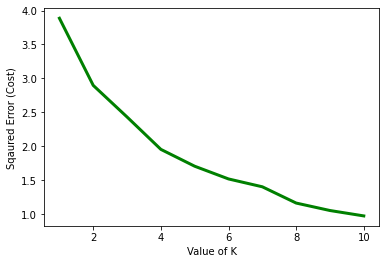

In [195]:
# Let's focus on the venues only
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# Let's gather the cost in a list
cost = []
# set range of clusters to search the optimal solution for

rangeofK = range(1,11)

for i in rangeofK:
    kclusters = i

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10]
  
    cost.append(kmeans.inertia_)
  
# plot the cost against K values 
plt.plot(rangeofK, cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()
# print(cost)

The above graph does not appear to be very conclusive as the Elbow is not very prominent. Let's now use the Silhouette score to identify the best k. Silhouette needs at least two clusters to start with

In [196]:
# import dependencies
from sklearn.metrics import silhouette_score

sil = []
toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)
rangeofK = range(2,11)

for i in rangeofK:
    kclusters = i

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, n_init=20, random_state=0).fit(toronto_grouped_clustering)
    sil.append(silhouette_score(toronto_grouped_clustering, kmeans.labels_, metric = 'euclidean'))

Let's plot the Silhouette Scores against K. It reaches its global maximum at the optimal K

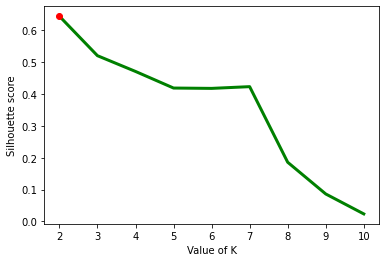

Max silhouette score: 0.6442534130028211 at k: 2


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [197]:
# Find the optimal K
npsil = np.array(sil)
kclusters = npsil.argmax() + 2 # We started with 2

# plot the Silhouette score against K
plt.plot(rangeofK, sil, color ='g', linewidth ='3')
plt.plot(kclusters, npsil.max(), 'ro')
plt.xlabel("Value of K") 
plt.ylabel("Silhouette score")
plt.show()

print("Max silhouette score:", npsil.max(), "at k:", npsil.argmax() + 2)

# run k-means clustering with optimal K
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

In [198]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = tslice

# add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

print(toronto_merged.head())

  Postal Code           Borough                                Neighbourhood  \
0         M5A  Downtown Toronto                    Regent Park, Harbourfront   
1         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
2         M5B  Downtown Toronto                     Garden District, Ryerson   
3         M5C  Downtown Toronto                               St. James Town   
4         M4E      East Toronto                                  The Beaches   

    Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  43.654260 -79.360636               0           Coffee Shop   
1  43.662301 -79.389494               0           Coffee Shop   
2  43.657162 -79.378937               0        Clothing Store   
3  43.651494 -79.375418               0            Restaurant   
4  43.676357 -79.293031               0                 Trail   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                Bakery                   Pub            

Let's find how the neighbourhoods have been clustered

In [199]:
toronto_merged.groupby('Cluster Labels').Borough.count()

Cluster Labels
0    38
1     1
Name: Borough, dtype: int64

## **Answer 3: Maps to visualize the neighborhoods and how they cluster together**

In [200]:
# create map
map_clusters = folium.Map(location=[lati, long], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's examine each cluster and determine the discriminating venue categories that distinguish each cluster

In [203]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]-5))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Regent Park, Harbourfront",0,Coffee Shop,Bakery,Pub,Park,Breakfast Spot
1,"Queen's Park, Ontario Provincial Government",0,Coffee Shop,Diner,Yoga Studio,Park,Music Venue
2,"Garden District, Ryerson",0,Clothing Store,Coffee Shop,Café,Italian Restaurant,Bubble Tea Shop
3,St. James Town,0,Restaurant,Café,Coffee Shop,Clothing Store,American Restaurant
4,The Beaches,0,Trail,Neighborhood,Pub,Health Food Store,Doner Restaurant
5,Berczy Park,0,Coffee Shop,Seafood Restaurant,Cocktail Bar,Beer Bar,Bakery
6,Central Bay Street,0,Coffee Shop,Sandwich Place,Café,Italian Restaurant,Japanese Restaurant
7,Christie,0,Grocery Store,Café,Park,Baby Store,Coffee Shop
8,"Richmond, Adelaide, King",0,Coffee Shop,Café,Restaurant,Clothing Store,Gym
9,"Dufferin, Dovercourt Village",0,Bakery,Pharmacy,Middle Eastern Restaurant,Supermarket,Bank


In [202]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,1,Garden,Yoga Studio,Department Store,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant


### Naming clusters based on the characteristics of the top common venues in the neighbourhoods

Cluster | Recommended Name | Comments
--- | --- | ---
`0` | **Foodies Delight** | *One or more of the top 5 common venues in the neighbourhood serve food and/or beverages*
`1` | **Alloy** | *Mixed venues with a bias for food*